In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Loading the dataset

In [2]:
# Loading the dataset
data = pd.read_csv('Tweets.csv')  


In [3]:
# datatype info
data.head()


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
data.drop('textID', axis=1, inplace=True)

In [5]:
data.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# Pre-processing the Dataset 

In [6]:
#lower casing 
data['selected_text'] = data['selected_text'].str.lower()


In [7]:
# Handling Missing Values
data['selected_text'].fillna('', inplace=True)


In [8]:
#removing punctuation i
import string
data['selected_text'] = data['selected_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [9]:
# Removing Stopwords
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['selected_text'] = data['selected_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))



In [10]:
# Tokenization
data['selected_text'] = data['selected_text'].apply(lambda x: nltk.word_tokenize(x))


In [11]:
data.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","[id, responded, going]",neutral
1,Sooo SAD I will miss you here in San Diego!!!,"[sooo, sad]",negative
2,my boss is bullying me...,[bullying],negative
3,what interview! leave me alone,"[leave, alone]",negative
4,"Sons of ****, why couldn`t they put them on t...",[sons],negative


# Visualize Data

<AxesSubplot:xlabel='sentiment', ylabel='count'>

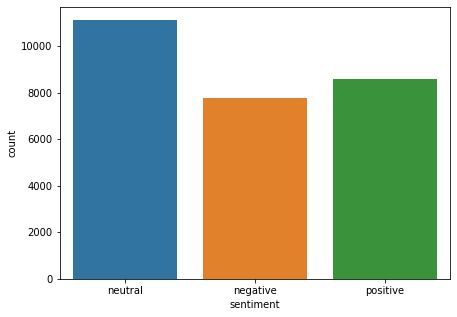

In [12]:
# Visualize sentiment distribution
fig = plt.figure(figsize=(7,5))
sns.countplot(x="sentiment",data=data)


Text(0.5, 1.0, 'Distribution of sentiments')

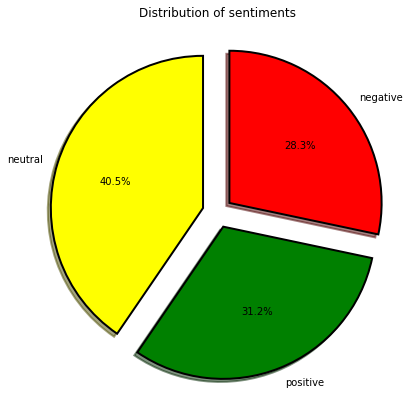

In [13]:
fig = plt.figure(figsize=(7,7), facecolor='white')
colors = ("yellow", "green", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = data['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

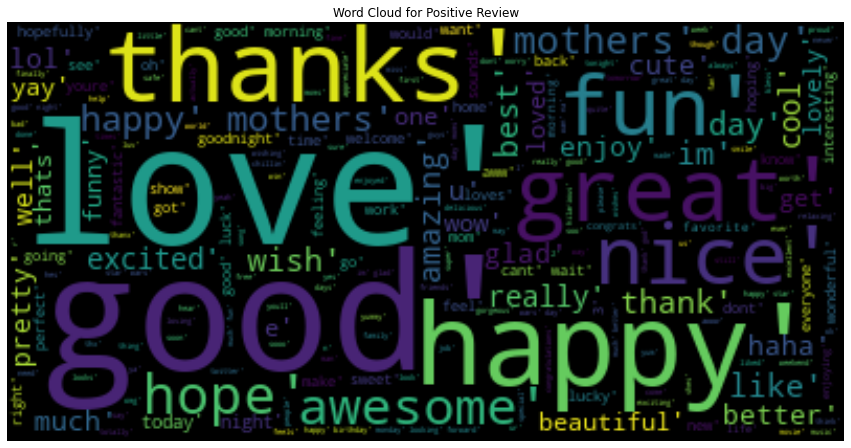

In [14]:

# Wordcloud for positive review
text = " ".join(str(i) for i in data[data['sentiment'] == 'positive']['selected_text'])
wordcloud = WordCloud(background_color="black").generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Review')
plt.show()



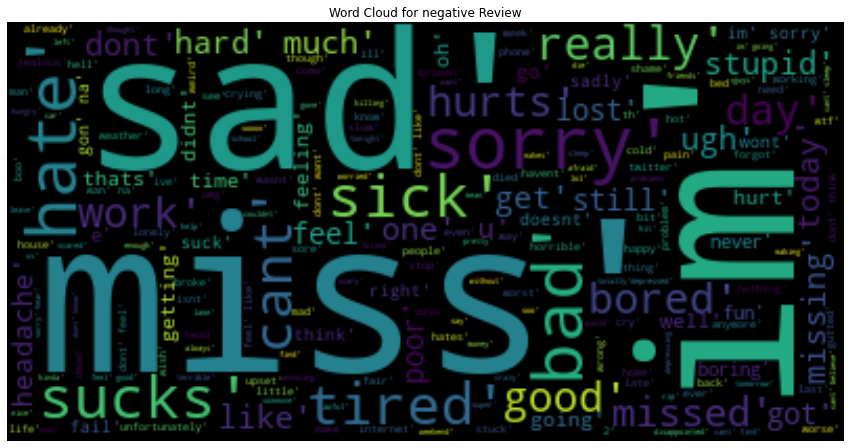

In [15]:
# Wordcloud for negative review
text = " ".join(str(i) for i in data[data['sentiment'] == 'negative']['selected_text'])
wordcloud = WordCloud(background_color="black").generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for negative Review')
plt.show()

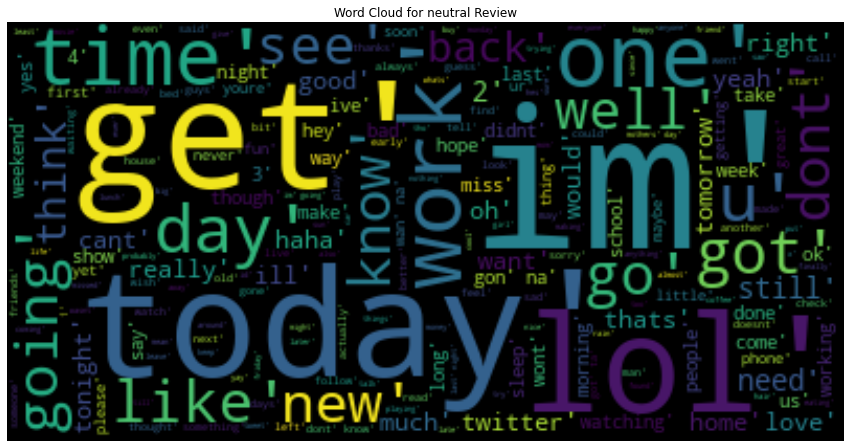

In [16]:
# Wordcloud for neutral review
text = " ".join(str(i) for i in data[data['sentiment'] == 'neutral']['selected_text'])
wordcloud = WordCloud(background_color="black").generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for neutral Review')
plt.show()

# Data Preparation and Model Initialization

In [17]:
# Label Encoding and Train-Test Split
le = LabelEncoder()
X = data['selected_text'].astype(str)
y = le.fit_transform(data['sentiment'])

# Map sentiment labels to 0, 1, 2 for negative, neutral, positive
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['sentiment_label'] = data['sentiment'].map(sentiment_mapping)
y = data['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [18]:
# Feature extraction using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', analyzer='word')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
# Define classifiers
naive_bayes = MultinomialNB()
logistic_regression = LogisticRegression(max_iter=1000) 

In [20]:
# Ensemble Model 
ensemble_model = VotingClassifier(estimators=[
    ('naive_bayes', naive_bayes),
    ('logistic_regression', logistic_regression)
], voting='soft')

In [21]:
# Fit ensemble model
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('naive_bayes', MultinomialNB()),
                             ('logistic_regression',
                              LogisticRegression(max_iter=1000))],
                 voting='soft')

# Predictions and metrics 

In [22]:
# Predictions
y_pred = ensemble_model.predict(X_test_tfidf)


In [23]:
# metrics
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.7765918738629473

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.62      0.72      2334
           1       0.70      0.89      0.78      3336
           2       0.86      0.77      0.82      2575

    accuracy                           0.78      8245
   macro avg       0.81      0.76      0.77      8245
weighted avg       0.79      0.78      0.77      8245



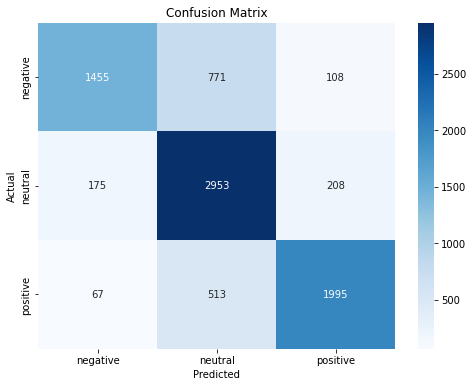

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming confusion_matrix is the variable containing your confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_mapping.keys(), yticklabels=sentiment_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()